# **Prediction of X-day ICU readmission**
    NGUYEN Dinh-Phong
    DIM HuPS / AP-HP WIND
    
Walkthrough notebook on prediction of ICU readmission, documenting the steps to reproduce the results of :

Needs Spark v2.3.0

*NB: to launch everything in one go instead of a cell-by-cell walkthrough, please refer to the end of this notebook after importing the packages and instantiating the parameters*

## **Importing packages**

In [1]:
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

from omopML import *

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, QuantileTransformer
)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, auc, roc_auc_score, roc_curve, log_loss, 
    f1_score, precision_score, recall_score, make_scorer
)

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

## **Instantiating parameters**

In [2]:
# OMOP tables to keep and their columns
tables_dict = {
    "person": [
        "person_id", 
        "gender_concept_id", 
        "year_of_birth", 
        "month_of_birth", 
        "day_of_birth", 
        "birth_datetime", 
        "race_concept_id", 
        "ethnicity_concept_id", 
    ],
    "death": [
        "person_id", 
        "death_date", 
        "death_type_concept_id", 
        "cause_concept_id",
    ],
    "visit_occurrence": [
        "visit_occurrence_id",
        "person_id",
        "admitting_source_concept_id",
    ],
    "visit_detail": [
        "visit_detail_id",
        "visit_occurrence_id",
        "visit_detail_concept_id",
        "visit_type_concept_id",
        "preceding_visit_detail_id",
        "visit_start_date",
        "visit_end_date",
        "discharge_to_concept_id",
    ],
    "measurement": [
        "measurement_id",
        "visit_occurrence_id",
        "visit_detail_id",
        "measurement_concept_id",
        "measurement_datetime",
        "measurement_type_concept_id",
        "value_as_number",
    ],
    "note": [
        "note_id",
        "person_id",
        "note_date"
    ],
    "note_nlp": [
        "note_id",
        "lexical_variant"
    ]
}

# Optional filter conditions
conditions_dict = {}

# Measurement names and their OMOP ID
measurements_dict = {
    "glasgow_motor": 3008223,
    "glasgow_verbal": 3009094,
    "glasgow_eye": 3016335,
    "systolic_bp": 3004249,
    "heart_rate": 3027018,
    "resp_rate": 3024171,
    "body_temp": 3020891,
    "sao2": 3016502,
    "fio2": 3020716,
    "body_weight": 3025315,
    "urine_output": 3014315,
    "serum_bicarbonate": 3016293,
    "serum_urea": 3013682,
    "total_bilirubin": 3024128,
    "direct_bilirubin": 3027597,
    "indirect_bilirubin": 3007359,
    "serum_sodium": 3019550,
    "serum_potassium": 3023103,
    "serum_creatinine": 3016723,
    "blood_platelets": 3024929,
    "blood_hemoglobin": 3000963,
    "blood_hematocrit": 3023314,
    "blood_leukocytes": 3003282,
    "serum_lactates": 3047181,
    "blood_ph": 3010421,
    "blood_glucose": 3004501,
    "INR": 3022217,
}

# Features types
features_dict = {
    "gender": np.bool,
    "length_of_stay": np.int32,
    "age": np.int32,
    "visit_detail_rank": np.int32,
    "first_glasgow_total": np.int32,
    "first_glasgow_motor": np.int32,
    "first_glasgow_verbal": np.int32,
    "first_glasgow_eye": np.int32,
    "first_systolic_bp": np.int32,
    "first_heart_rate": np.int32,
    "first_resp_rate": np.int32,
    "first_body_temp": np.float32,
    "first_sao2": np.float32,
    "first_fio2": np.float32,
    "first_body_weight": np.float32,
    "first_urine_output": np.float32,
    "first_serum_bicarbonate": np.float32,
    "first_serum_urea": np.float32,
    "first_total_bilirubin": np.float32,
    "first_serum_sodium": np.float32,
    "first_serum_potassium": np.float32,
    "first_serum_creatinine": np.float32,
    "first_blood_platelets": np.float32,
    "first_blood_hemoglobin": np.float32,
    "first_blood_hematocrit": np.float32,
    "first_blood_leukocytes": np.float32,
    "first_serum_lactates": np.float32,
    "first_blood_ph": np.float32,
    "first_blood_glucose": np.float32,
    "first_INR": np.float32,
    "last_glasgow_total": np.int32,
    "last_glasgow_motor": np.int32,
    "last_glasgow_verbal": np.int32,
    "last_glasgow_eye": np.int32,
    "last_systolic_bp": np.int32,
    "last_heart_rate": np.int32,
    "last_resp_rate": np.int32,
    "last_body_temp": np.float32,
    "last_sao2": np.float32,
    "last_fio2": np.float32,
    "last_body_weight": np.float32,
    "last_urine_output": np.float32,
    "last_serum_bicarbonate": np.float32,
    "last_serum_urea": np.float32,
    "last_total_bilirubin": np.float32,
    "last_serum_sodium": np.float32,
    "last_serum_potassium": np.float32,
    "last_serum_creatinine": np.float32,
    "last_blood_platelets": np.float32,
    "last_blood_hemoglobin": np.float32,
    "last_blood_hematocrit": np.float32,
    "last_blood_leukocytes": np.float32,
    "last_serum_lactates": np.float32,
    "last_blood_ph": np.float32,
    "last_blood_glucose": np.float32,
    "last_INR": np.float32,
    "delta_glasgow_total": np.int32,
    "delta_glasgow_motor": np.int32,
    "delta_glasgow_verbal": np.int32,
    "delta_glasgow_eye": np.int32,
    "delta_systolic_bp": np.int32,
    "delta_heart_rate": np.int32,
    "delta_resp_rate": np.int32,
    "delta_body_temp": np.float32,
    "delta_sao2": np.float32,
    "delta_fio2": np.float32,
    "delta_body_weight": np.float32,
    "delta_urine_output": np.float32,
    "delta_serum_bicarbonate": np.float32,
    "delta_serum_urea": np.float32,
    "delta_total_bilirubin": np.float32,
    "delta_serum_sodium": np.float32,
    "delta_serum_potassium": np.float32,
    "delta_serum_creatinine": np.float32,
    "delta_blood_platelets": np.float32,
    "delta_blood_hemoglobin": np.float32,
    "delta_blood_hematocrit": np.float32,
    "delta_blood_leukocytes": np.float32,
    "delta_serum_lactates": np.float32,
    "delta_blood_ph": np.float32,
    "delta_blood_glucose": np.float32,
    "delta_INR": np.float32,
    "from_surgery": np.bool,
    "history_aids": np.bool,
    "history_metastases": np.bool,
    "history_hemato": np.bool,
    "full_count": np.int32
}

# Outcome parameters
label = "readmission"
time_to_readmission = 3

# Evaluation metrics
metrics_dict = {
    "accuracy": accuracy_score,
    "roc_auc": auc,
    "f1": f1_score,
    "precision" : precision_score,
    "recall" : recall_score
}

# Optional data normalizer
scaler = QuantileTransformer(n_quantiles=20, output_distribution="uniform")

seed = 42

## **Detailed walkthrough**

## Loading data

In [3]:
%%time
loader = DataLoader("mimicomop", tables_dict, measurements_dict)
loader.load(sqlContext)
loader.filter(conditions_dict)
loader.create_dataset()
df = loader.dataset.toPandas()
df = df.drop_duplicates(["person_id", "visit_start_date"])

CPU times: user 17.4 s, sys: 349 ms, total: 17.7 s
Wall time: 1min 31s


## Adding study specific features

In [4]:
# Gender
df["gender"] = (df["gender_concept_id"] == 8532)

# Age and age binning
df["age"] = df["visit_start_date"].dt.year - df["year_of_birth"]
df = df[df["age"] >= 18]
age_bins = [0, 18, 25, 45, 65, 85, 95, 350]
df["age"] = pd.cut(df["age"], age_bins, right=False, labels=False)

# Length of stay
df["length_of_stay"] = (df["visit_end_date"] - df["visit_start_date"]).dt.days

# Total GCS from parts
df["first_glasgow_total"] = np.sum(
    df[["first_glasgow_motor", "first_glasgow_verbal", "first_glasgow_eye"]],
    axis=1
)
df["last_glasgow_total"] = np.sum(
    df[["last_glasgow_motor", "last_glasgow_verbal", "last_glasgow_eye"]],
    axis=1
)

# Differences between first and last available measurement in ICU
for column in df.columns:
    if column[:5] == "first":
        df["delta_{}".format(column[6:])] = np.abs(df["last_{}".format(column[6:])] - df[column])

## Explorating correlations and missing data

In [5]:
preprocessor = Preprocessor(df, features_dict, label, time_to_readmission)

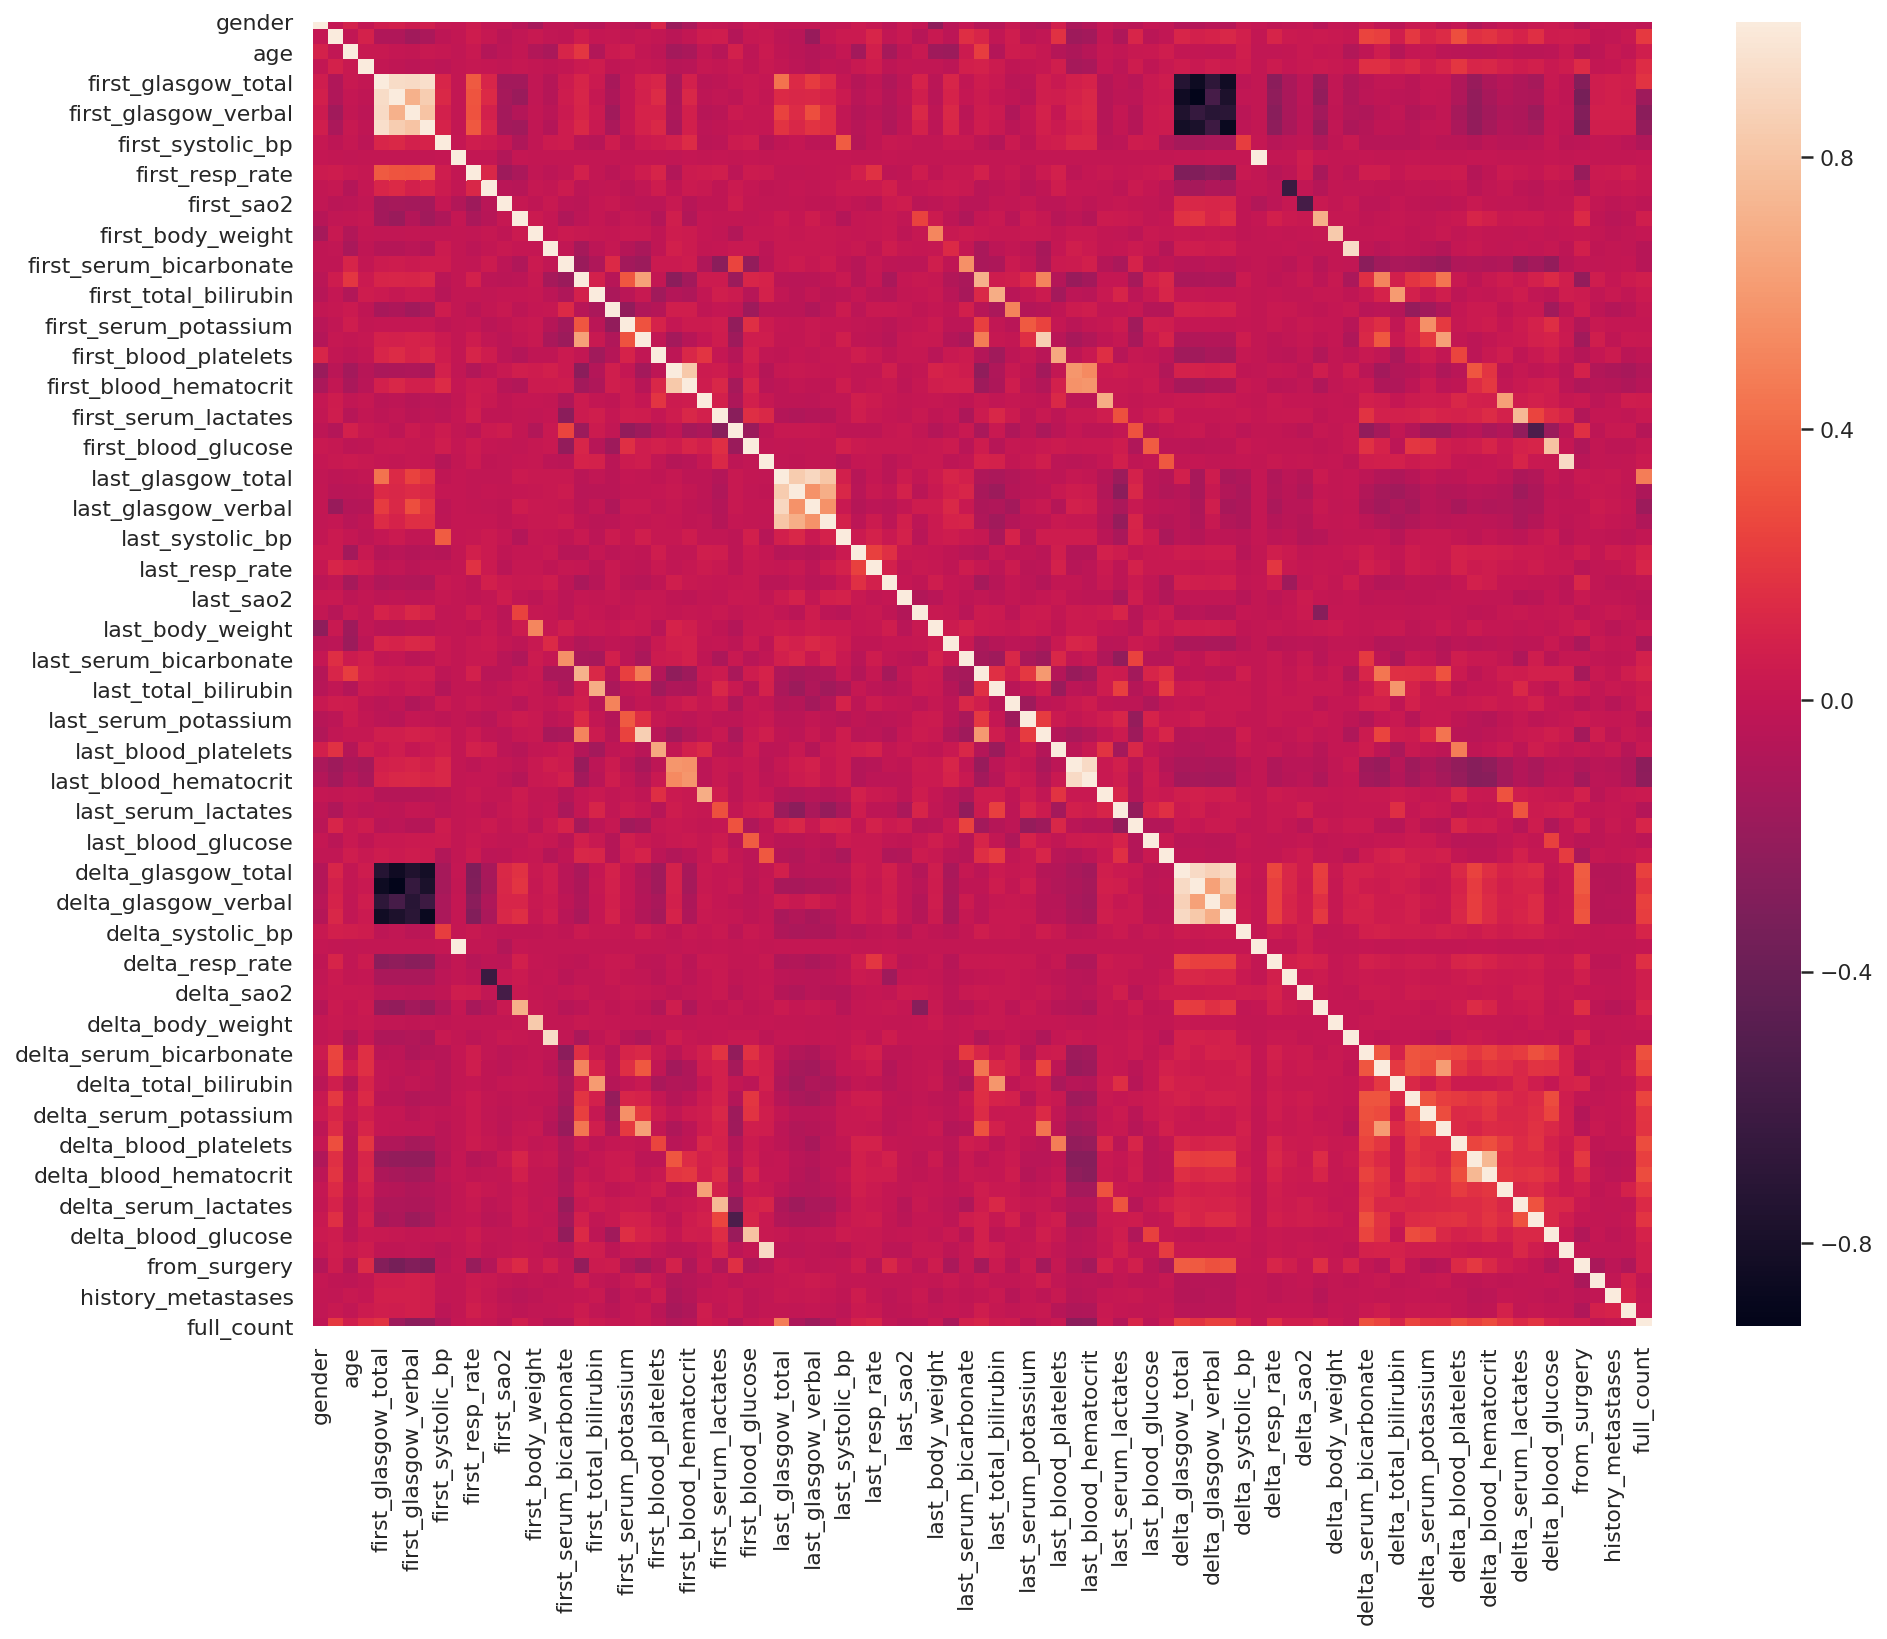

In [6]:
preprocessor.plot_corr_heatmap()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


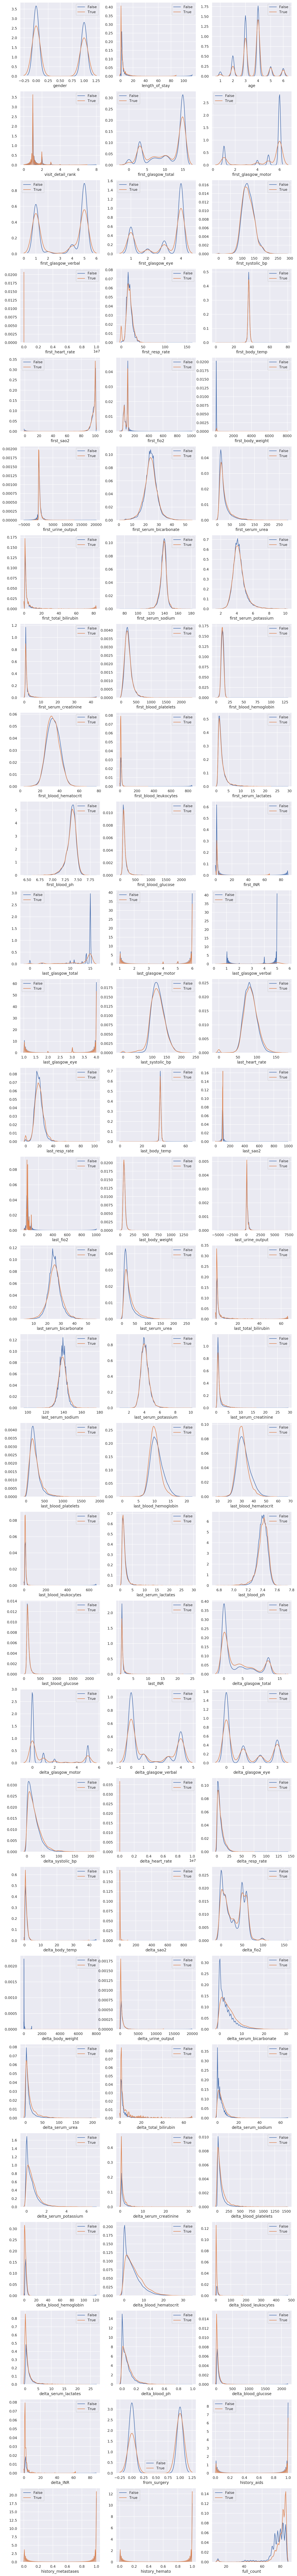

In [7]:
preprocessor.plot_dist_label()

## Missing data

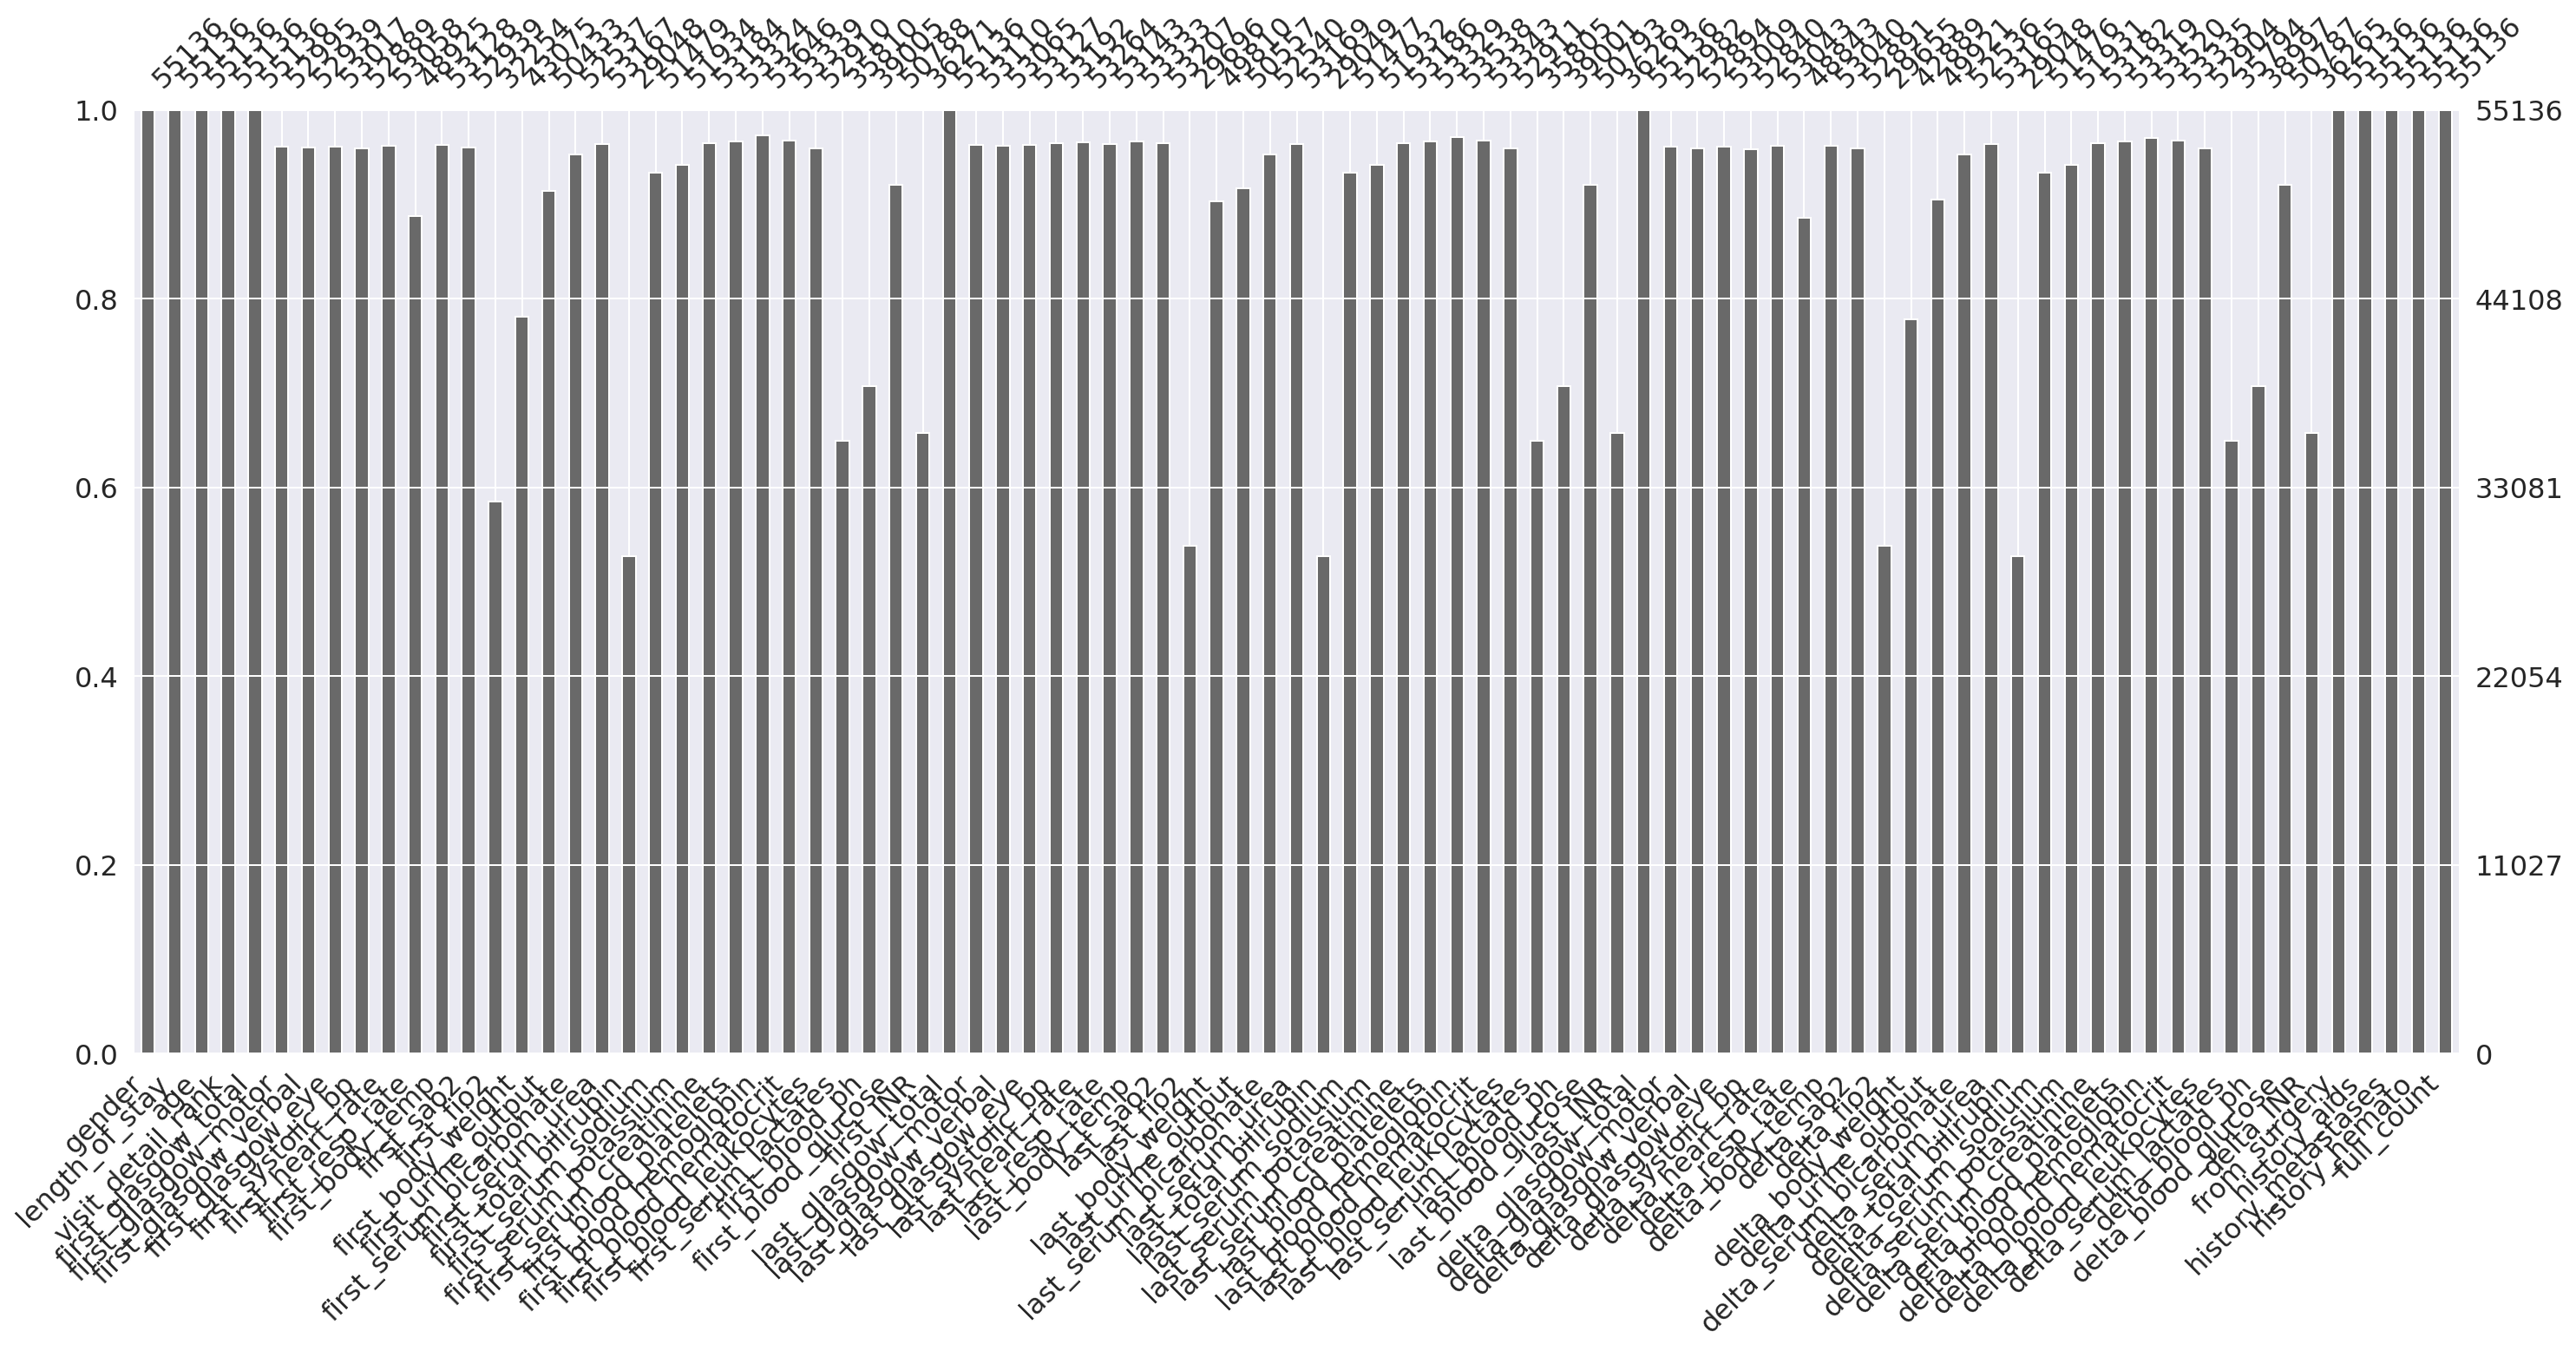

In [8]:
msno.bar(preprocessor.X, labels=True);

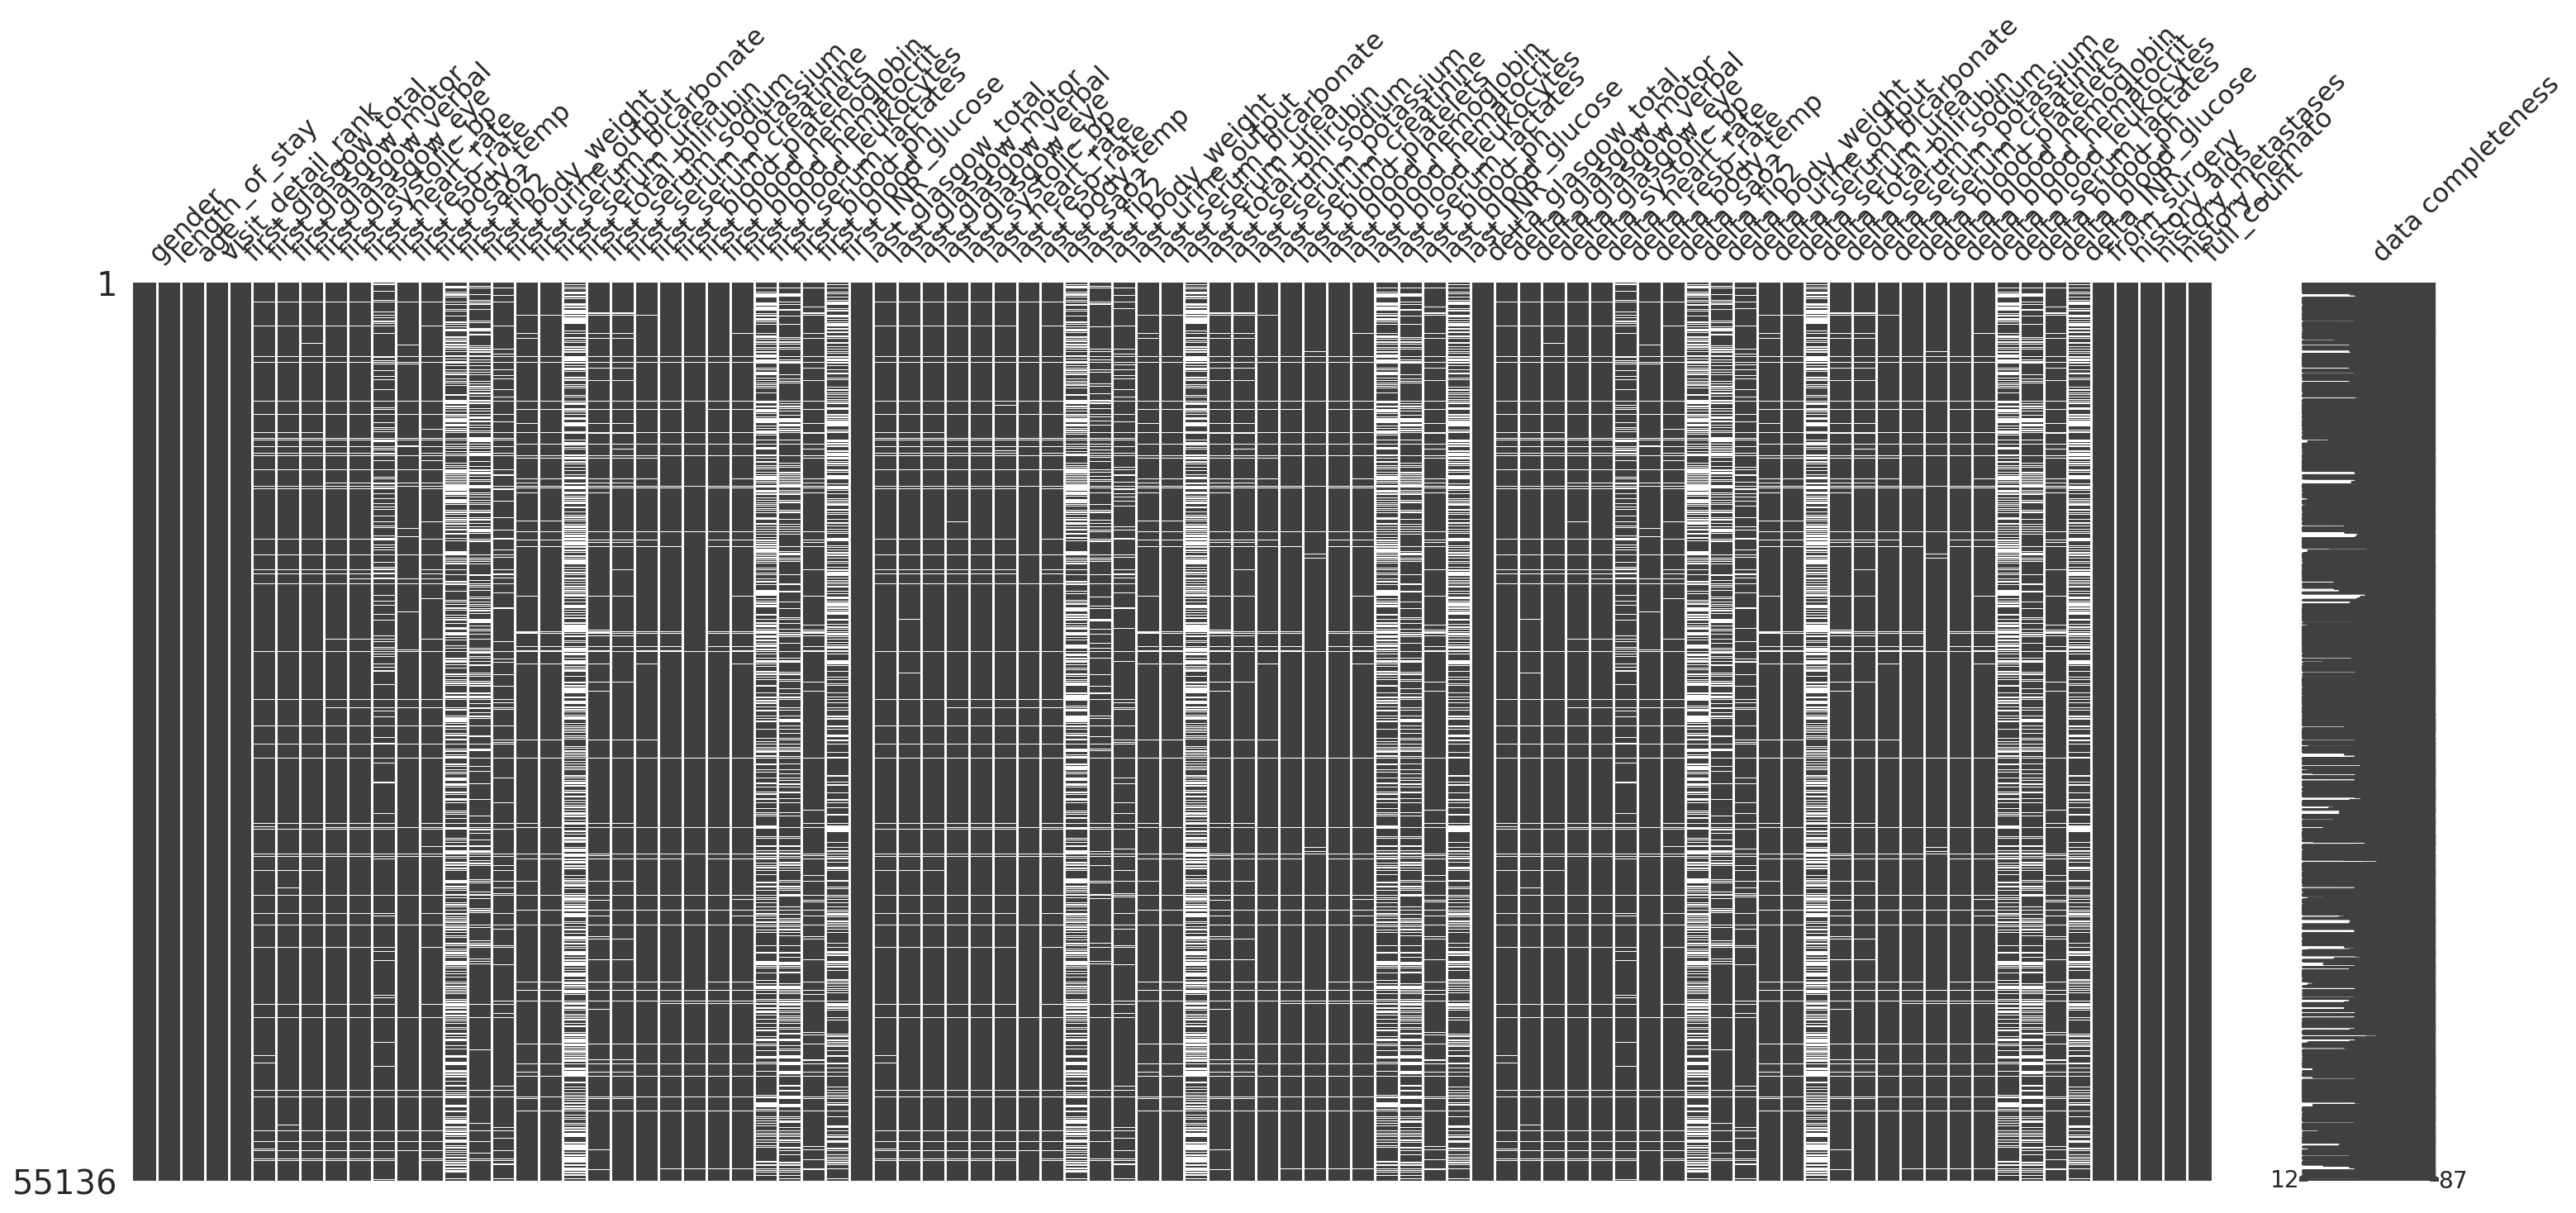

In [9]:
msno.matrix(preprocessor.X, labels=True);

## Preprocessing

In [10]:
%%time
# X_train, X_test, y_train, y_test = preprocessor.split(test_size=0.1)
# X_train = preprocessor.fit_transform(X_train, scaler=scaler)
# X_test = preprocessor.transform(X_test)

X_train = preprocessor.fit_transform(preprocessor.X, preprocessor.y, imputing_strategy="iterative")
y_train = preprocessor.fitted_labels

CPU times: user 3min 32s, sys: 7min 43s, total: 11min 15s
Wall time: 19.6 s


## Model training

In [11]:
clf = XGBClassifier(
    n_estimators=200, 
    max_depth=5,
    learning_rate=.1,
    colsample_bytree=.7,
    random_state=seed,
    gpu_id=0,
    tree_method="gpu_hist"
)

clf.fit(np.array(X_train), np.array(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

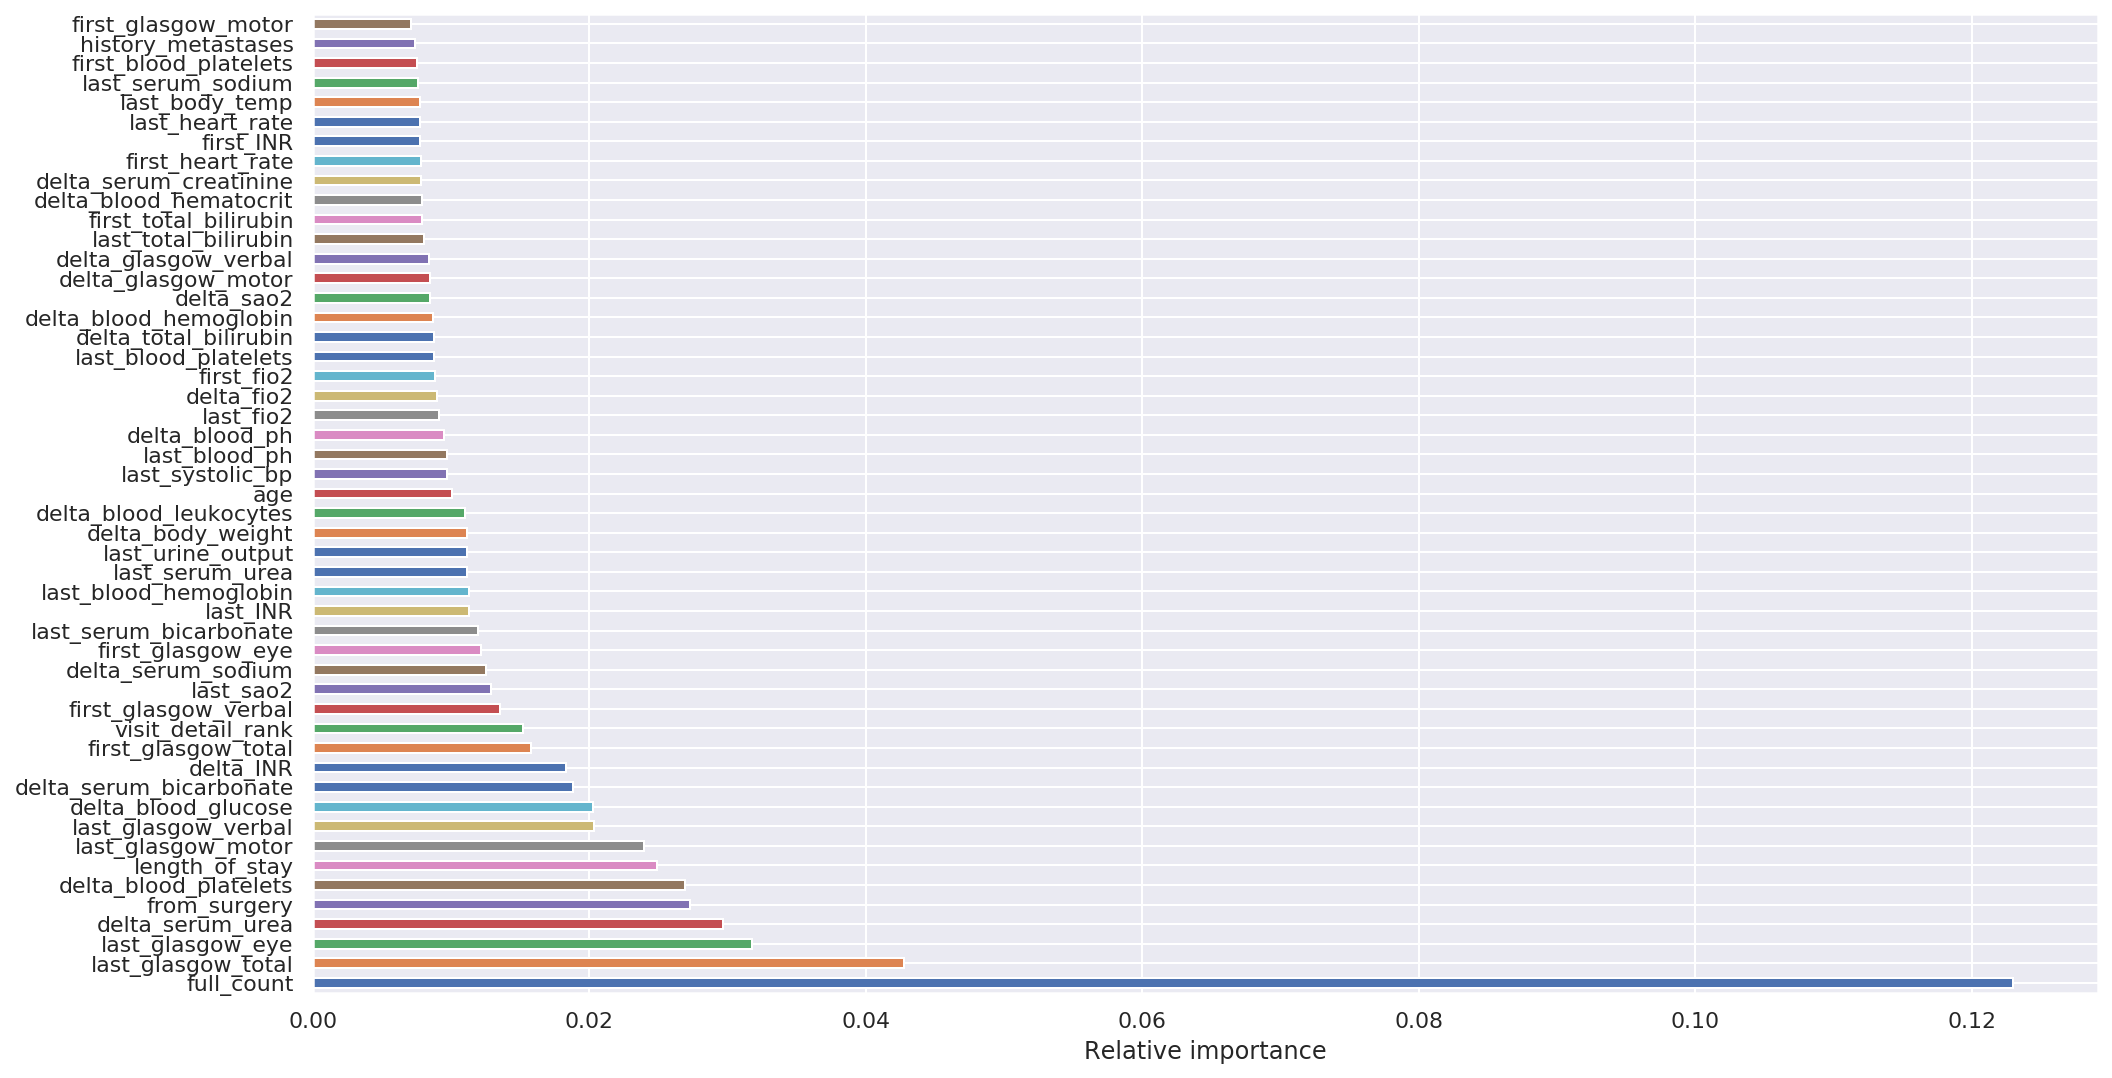

In [12]:
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
plt.figure(figsize=(16, 9))
feature_importances.nlargest(50).plot(kind='barh');
plt.xlabel("Relative importance");

## Evaluation

In [13]:
evaluator = ModelEvaluator(
    clf, np.array(X_train), np.array(y_train), metrics_dict,  y_train.sum()/len(X_train)
)

CPU times: user 8.16 s, sys: 9.07 s, total: 17.2 s
Wall time: 16.9 s


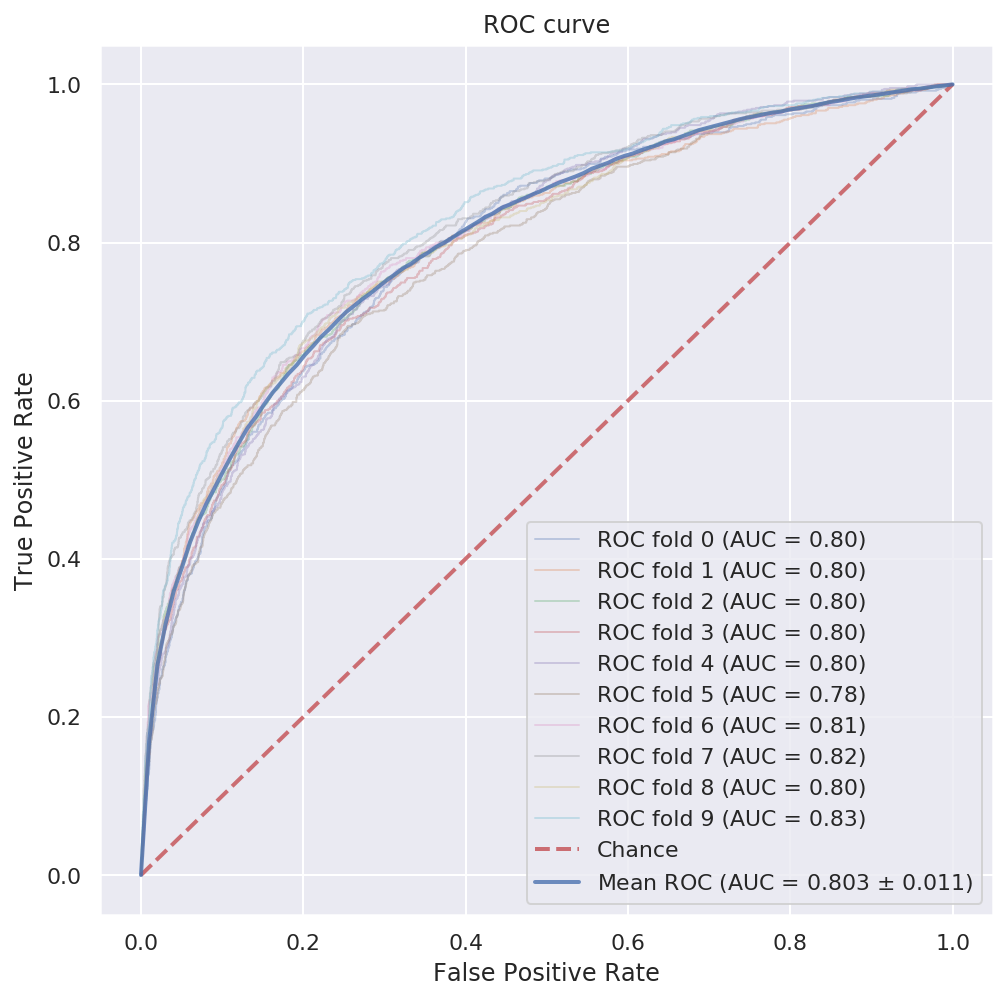

In [14]:
%%time
evaluator.cross_val(np.array(X_train), np.array(y_train), plot_auc=True, figsize=(8, 8))

In [15]:
%%time
cv_scores = evaluator.cross_val(np.array(X_train), np.array(y_train), plot_auc=False)
for metric in cv_scores :
    print("Mean {} : {}".format(metric, np.mean(cv_scores[metric])))

Mean accuracy : 0.7937823440870269
Mean roc_auc : 0.8031677287874084
Mean f1 : 0.36009545680026567
Mean precision : 0.4231334010487939
Mean recall : 0.8298299349149806
CPU times: user 50.8 s, sys: 45.7 s, total: 1min 36s
Wall time: 1min 34s


accuracy: 0.7932
roc_auc: 0.8937
f1: 0.5627
precision: 0.4232
recall: 0.8393


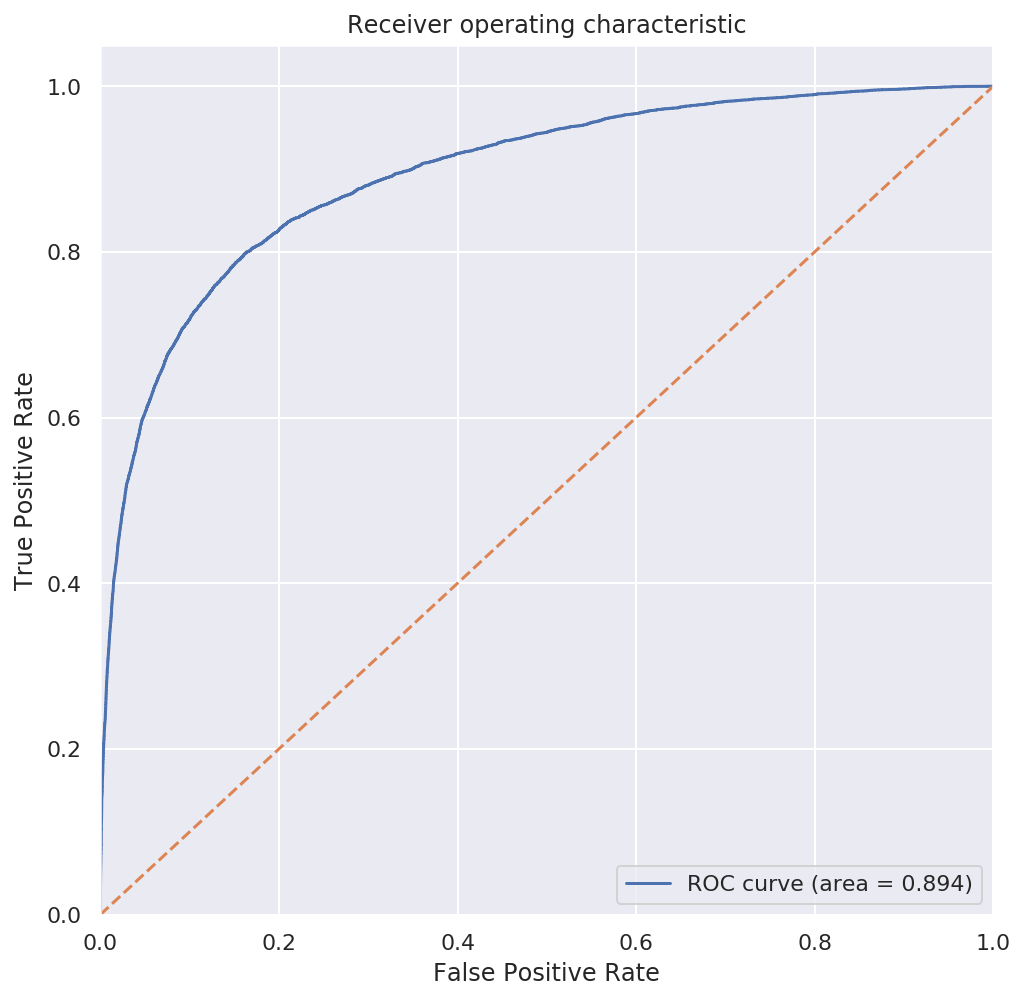

In [16]:
evaluator.compute_metrics()
evaluator.print_metrics()
evaluator.plot_roc()

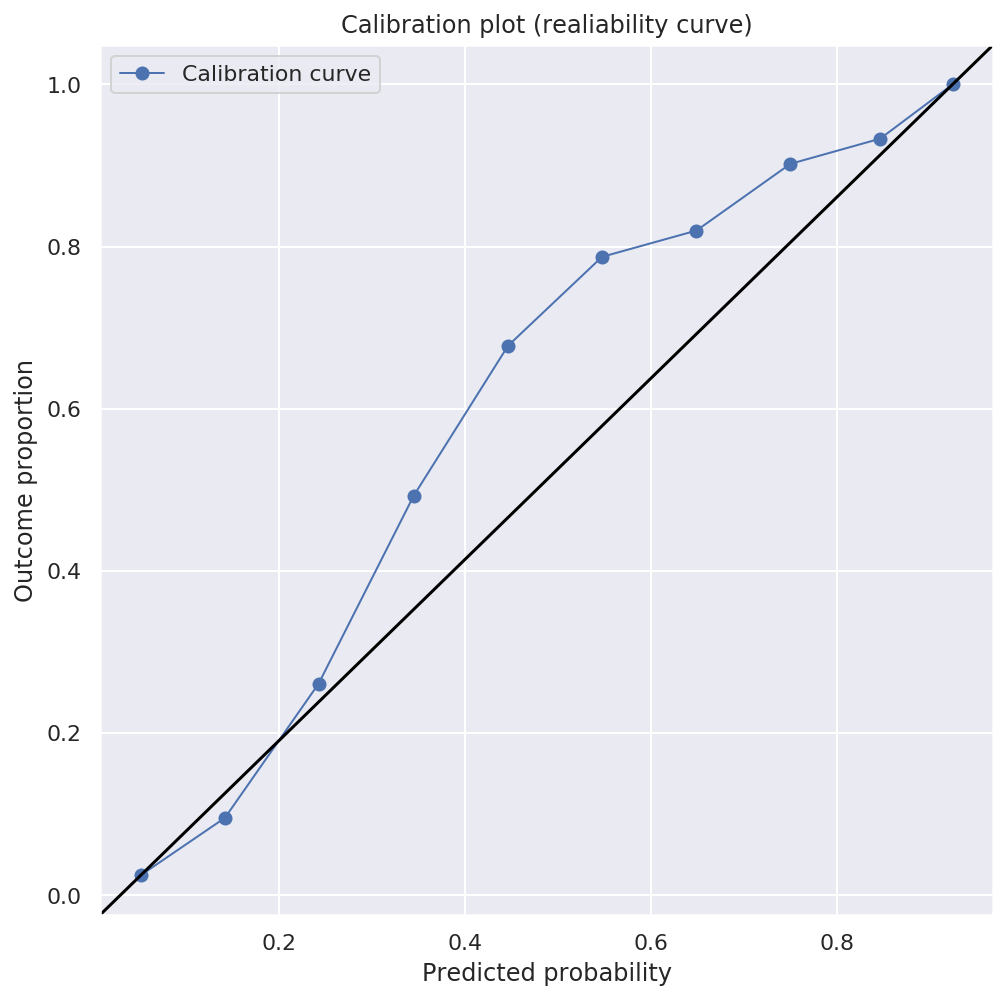

In [17]:
evaluator.plot_calibration()

## **Quick training** (all steps above)

In [18]:
%%time
time_to_readmission = 3

# LOADING
loader = DataLoader("mimicomop", tables_dict, measurements_dict)
loader.load(sqlContext)
loader.filter(conditions_dict)
loader.create_dataset()
df = loader.dataset.toPandas()
df = df.drop_duplicates(["person_id", "visit_start_date"])

# SPECIFIC FEATURES
df["gender"] = (df["gender_concept_id"] == 8532)
df["age"] = df["visit_start_date"].dt.year - df["year_of_birth"]
df = df[df["age"] >= 18]
age_bins = [0, 18, 25, 45, 65, 85, 95, 350]
df["age"] = pd.cut(df["age"], age_bins, right=False, labels=False)
df["length_of_stay"] = (df["visit_end_date"] - df["visit_start_date"]).dt.days
df["first_glasgow_total"] = np.sum(
    df[["first_glasgow_motor", "first_glasgow_verbal", "first_glasgow_eye"]],
    axis=1
)
df["last_glasgow_total"] = np.sum(
    df[["last_glasgow_motor", "last_glasgow_verbal", "last_glasgow_eye"]],
    axis=1
)
for column in df.columns:
    if column[:5] == "first":
        df["delta_{}".format(column[6:])] = np.abs(df["last_{}".format(column[6:])] - df[column])

# PREPROCESSING
preprocessor = Preprocessor(df, features_dict, label, time_to_readmission)
X_train = preprocessor.fit_transform(
    preprocessor.X, preprocessor.y, imputing_strategy="iterative"
)
y_train = preprocessor.fitted_labels

# TRAINING
clf = XGBClassifier(
    n_estimators=200, 
    max_depth=5,
    learning_rate=.1,
    colsample_bytree=.7,
    random_state=seed,
    gpu_id=0,
    tree_method="gpu_hist"
)
clf.fit(np.array(X_train), np.array(y_train))

#EVALUATING
evaluator = ModelEvaluator(
    clf, np.array(X_train), np.array(y_train), metrics_dict, y_train.sum()/len(X_train)
)
cv_scores = evaluator.cross_val(np.array(X_train), np.array(y_train), plot_auc=False)

CPU times: user 4min 45s, sys: 8min 21s, total: 13min 7s
Wall time: 3min 21s


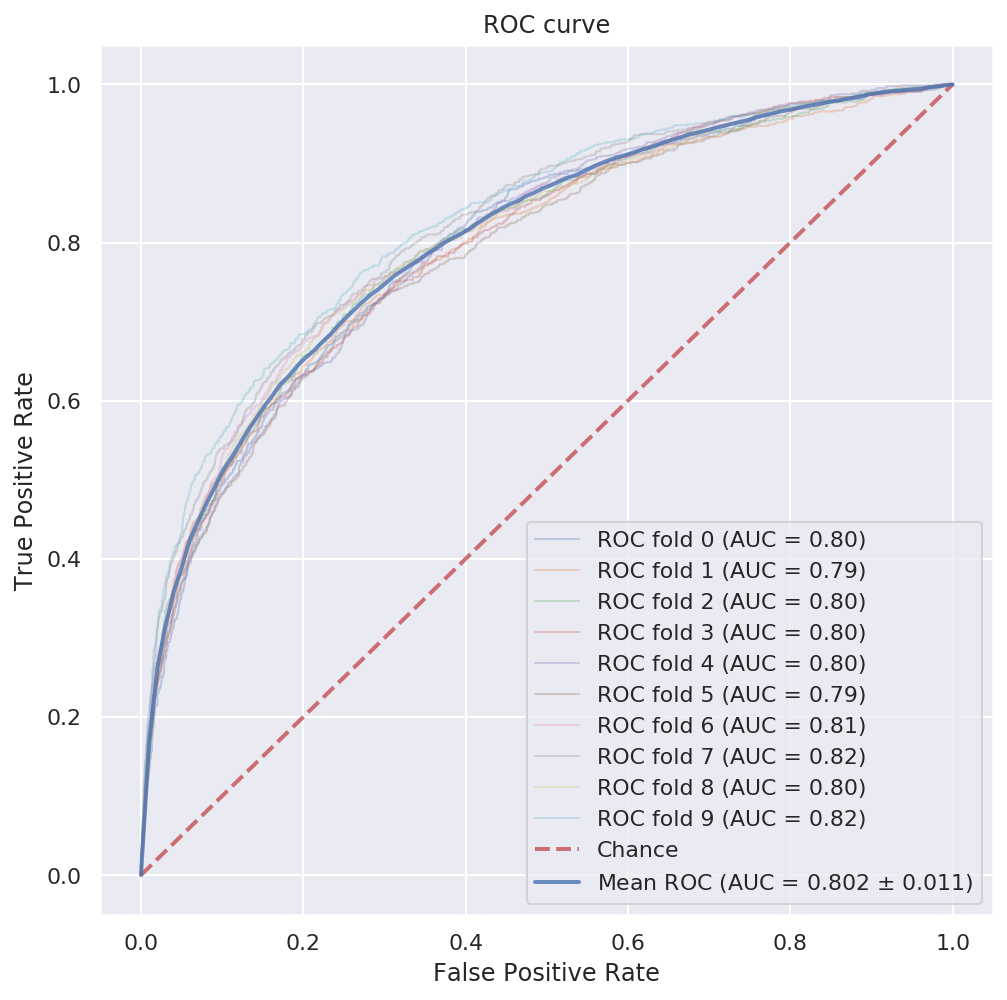

In [19]:
evaluator.cross_val(np.array(X_train), np.array(y_train), plot_auc=True, figsize=(8, 8))

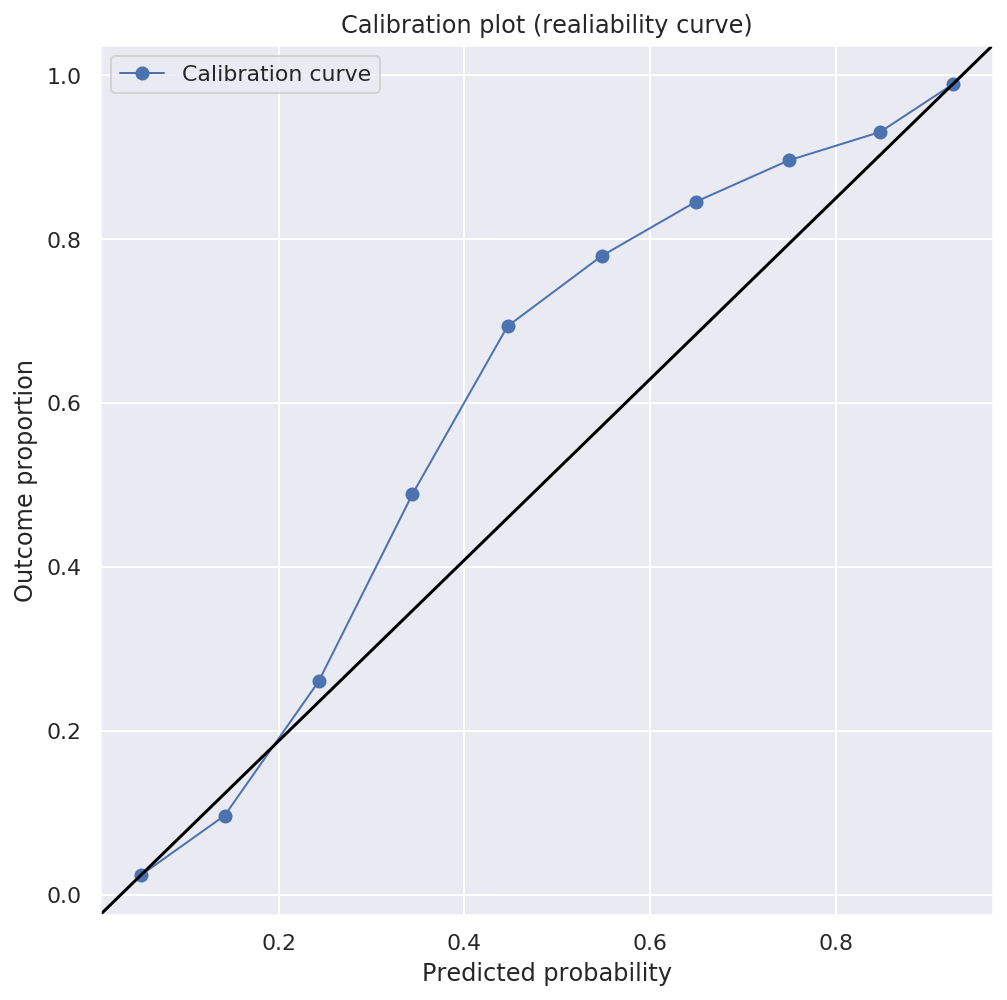

In [20]:
evaluator.plot_calibration()